In [1]:
%cd ..

/misc/vlgscratch4/LakeGroup/wentao/multimodal-baby


In [2]:
import argparse
import os
import glob

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl
# from pytorch_lightning.callbacks import ModelCheckpoint

from multimodal.multimodal_saycam_data_module import MultiModalSAYCamDataModule
from multimodal.coco_captions_data_module import COCOCaptionsDataModule
# from multimodal.multimodal import MultiModalModel
from multimodal.multimodal_lit import MultiModalLitModel
from multimodal.attention_maps import gradCAM, viz_attn, n_inv
from train import _setup_parser

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_checkpoint_name = "multimodal_text_encoder_lstm_lr_5e-05_weight_decay_0.1_fix_temperature_True_batch_size_8"
# model_checkpoint_name = "multimodal_text_encoder_embedding_lr_0.0001_weight_decay_0.1_fix_temperature_True_batch_size_16"
model_checkpoint = glob.glob(f"/home/wv9/code/WaiKeen/multimodal-baby/checkpoints/{model_checkpoint_name}/*.ckpt")[0]
#model_checkpoint = "checkpoints/multimodal_dataset_saycam_captioning_False_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_512_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_0/last.ckpt"
print(model_checkpoint)
# embedding_checkpoint = "/home/wv9/code/WaiKeen/multimodal-baby/checkpoints/multimodal_text_encoder_lstm_lr_5e-05_weight_decay_0.1_fix_temperature_True_batch_size_8/epoch=199.ckpt"
model = MultiModalLitModel.load_from_checkpoint(model_checkpoint, map_location=device)
model.eval()
print(model.hparams["args"])

/usr/local/stow/python-3.9/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


checkpoints/multimodal_dataset_saycam_captioning_False_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_512_lr_0.003_lr_scheduler_True_weight_decay_0.05_seed_0/last.ckpt
Namespace(logger=True, checkpoint_callback=True, enable_checkpointing=True, default_root_dir=None, gradient_clip_val=None, gradient_clip_algorithm=None, process_position=0, num_nodes=1, num_processes=1, devices=None, gpus=1, auto_select_gpus=False, tpu_cores=None, ipus=None, log_gpu_memory=None, progress_bar_refresh_rate=None, enable_progress_bar=True, overfit_batches=0.0, track_grad_norm=-1, check_val_every_n_epoch=1, fast_dev_run=False, accumulate_grad_batches=None, max_epochs=200, min_epochs=None, max_steps=-1, min_steps=None, max_time=None, limit_train_batches=1.0, limit_val_batches=1.0, limit_test_batches=1.0, limit_predict_batches=1.0, val_check_interval=1.0, flush_logs_every_n_steps=None, log_every_n_steps=50, accelerato

In [3]:
# parse empty args
parser = _setup_parser()
args = parser.parse_args("")
# set args
for key, value in model.args.items():
    setattr(args, key, value)
# make the train dataloader deterministic
args.augment_frames = False

# build data module
dataset_name = getattr(args, "dataset", "saycam")
DataModuleClass = {
    "saycam": MultiModalSAYCamDataModule,
    "coco": COCOCaptionsDataModule,
}[dataset_name]
data = DataModuleClass(args)
data.prepare_data()
data.setup()

vocab = data.read_vocab()
idx2word = {v: k for k, v in vocab.items()}

# eval datasets
eval_dev_dataset = data.eval_datasets["val"]
eval_test_dataset = data.eval_datasets["test"]

# dataloaders
eval_dev_dataloader = data.val_dataloader()[1]
eval_test_dataloader = data.test_dataloader()[1]

Calling prepare_data!
SAYCam transcripts have already been downloaded. Skipping this step.
Transcripts have already been renamed. Skipping this step.
Transcripts have already been preprocessed. Skipping this step.
Training frames have already been extracted. Skipping this step.
Training metadata files have already been created . Skipping this step.
Evaluation frames have already been extracted. Skipping this step.
Evaluation metadata files have already been created . Skipping this step.
Vocabulary file already exists. Skipping this step.
Calling setup!


/home/ww2135/.local/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:73: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


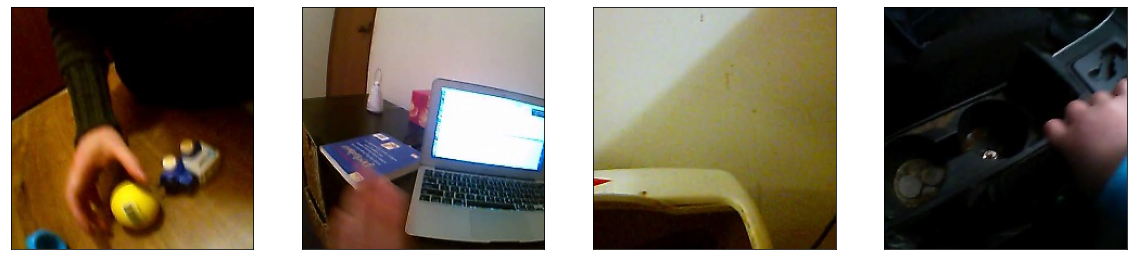

label: ball


In [4]:
# load a single example
# imgs, label, label_len, raw_label = next(iter(eval_dev_dataloader))
imgs, label, label_len, raw_label = eval_dev_dataset[29]
label_len = torch.tensor(label_len)

# display images
inv_imgs = imgs.squeeze(0)
inv_imgs = n_inv(inv_imgs)

import matplotlib.pyplot as plt

# extract first image from each batch
plt.figure(figsize=(20, 10))
for i in range(4):
    img = inv_imgs[i].permute((1, 2, 0))

    plt.subplot(1, 4, i+1)
    plt.imshow(img.detach().numpy())
    plt.xticks([])
    plt.yticks([])

plt.show()
    
# get label text
print("label:", raw_label[0])

normalizing:
min: -0.00061685714
max: 0.005472879


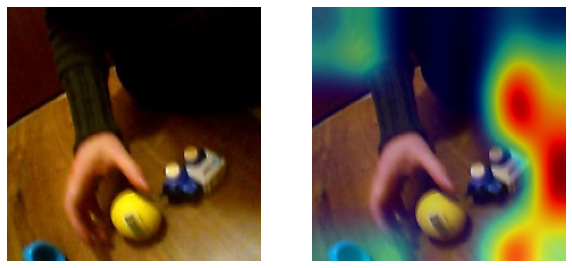

In [5]:
# print(model.vision_encoder)
saliency_layer = "layer4"

text_features = model.model.encode_text(label.unsqueeze(0).to(device), label_len.unsqueeze(0).to(device))[0]
if model.model.normalize_features:
    text_features = F.normalize(text_features, p=2, dim=1)

attn_map = gradCAM(
    model.vision_encoder.model,
    imgs[0].unsqueeze(0).to(device),
    text_features,
    getattr(model.vision_encoder.model, saliency_layer),
    normalize_features=model.model.normalize_features,
)
attn_map = attn_map.squeeze().detach().cpu().numpy()

np_img = inv_imgs[0].permute((1, 2, 0)).cpu().numpy()
blur = True
viz_attn(np_img, attn_map, blur, with_img=True)

Text(0.5, 1.0, 'ball')

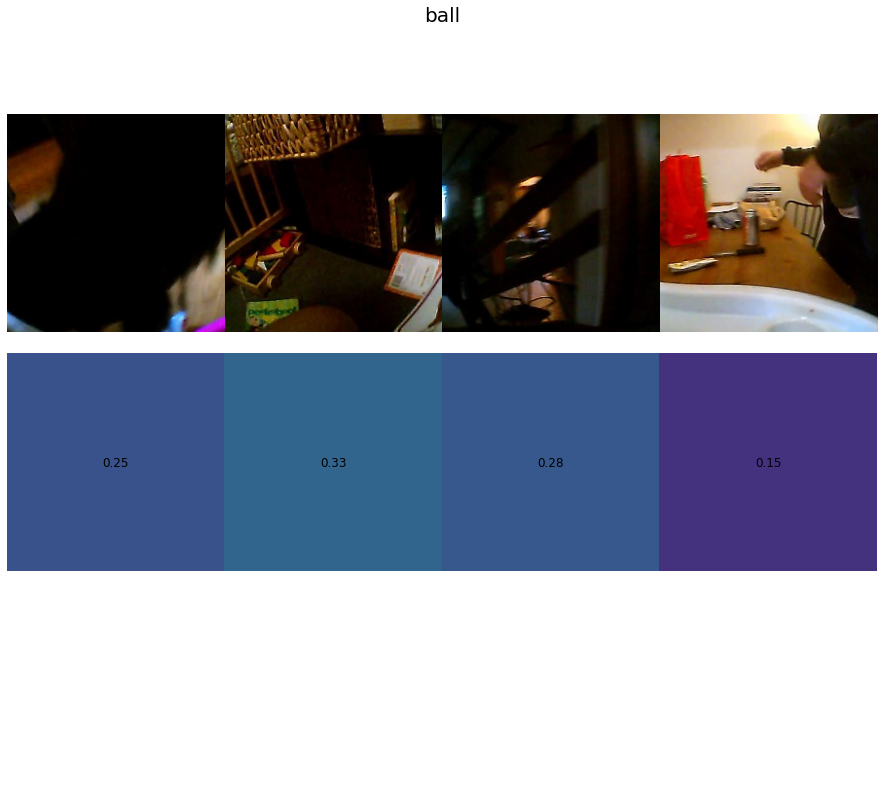

In [6]:
# eval trial
accuracy = 0
# for i in range(100):
imgs, label, label_len, raw_label = eval_dev_dataset[10]
label_len = torch.tensor(label_len)

# move to gpu
imgs = imgs.to(device)
label = label.to(device).unsqueeze(0)
label_len = label_len.to(device).unsqueeze(0)

# reshape imgs along batch dim
imgs = imgs.view(-1, *imgs.shape[-3:])

# calculate accuracy
logits_per_image, logits_per_text = model(imgs, label, label_len)
logits = logits_per_text[0]  # get logits per trial
probs = F.softmax(logits.detach(), dim=0).unsqueeze(0).cpu().numpy()
pred = torch.argmax(logits).item()
correct_label = 0  # correct answer is always the first item
accuracy += int(pred == correct_label)

# display images
inv_imgs = imgs.squeeze(0)
inv_imgs = n_inv(inv_imgs)

count = 1
plt.figure(figsize=(20, 14))
plt.imshow(probs, vmin=0.0, vmax=1.0)
# plt.colorbar()
plt.yticks([0, 1, 2, 3], raw_label[0], fontsize=18)
plt.xticks([])
for i, image in enumerate(inv_imgs):
    image = image.permute((1, 2, 0)).detach().cpu().numpy()
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(probs.shape[1]):
    for y in range(probs.shape[0]):
        plt.text(x, y, f"{probs[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, 4 - 0.5])
plt.ylim([1 + 0.5, -2])
plt.xticks([])
plt.yticks([])
plt.title(raw_label[0], size=20)

In [7]:
# validation set visualizations

def get_captions(labels, label_len):
    captions = []
    for i in range(len(labels)):
        label = labels[i][:label_len[i]][1:-1].cpu().numpy()
        caption = [idx2word[j] for j in label]
        caption = ' '.join(caption)
        captions.append(caption)
    return captions

train_dataloader = iter(data.train_dataloader(batch_size=8, shuffle=True))

Text(0.5, 1.0, 'Cosine similarity between text and image features')

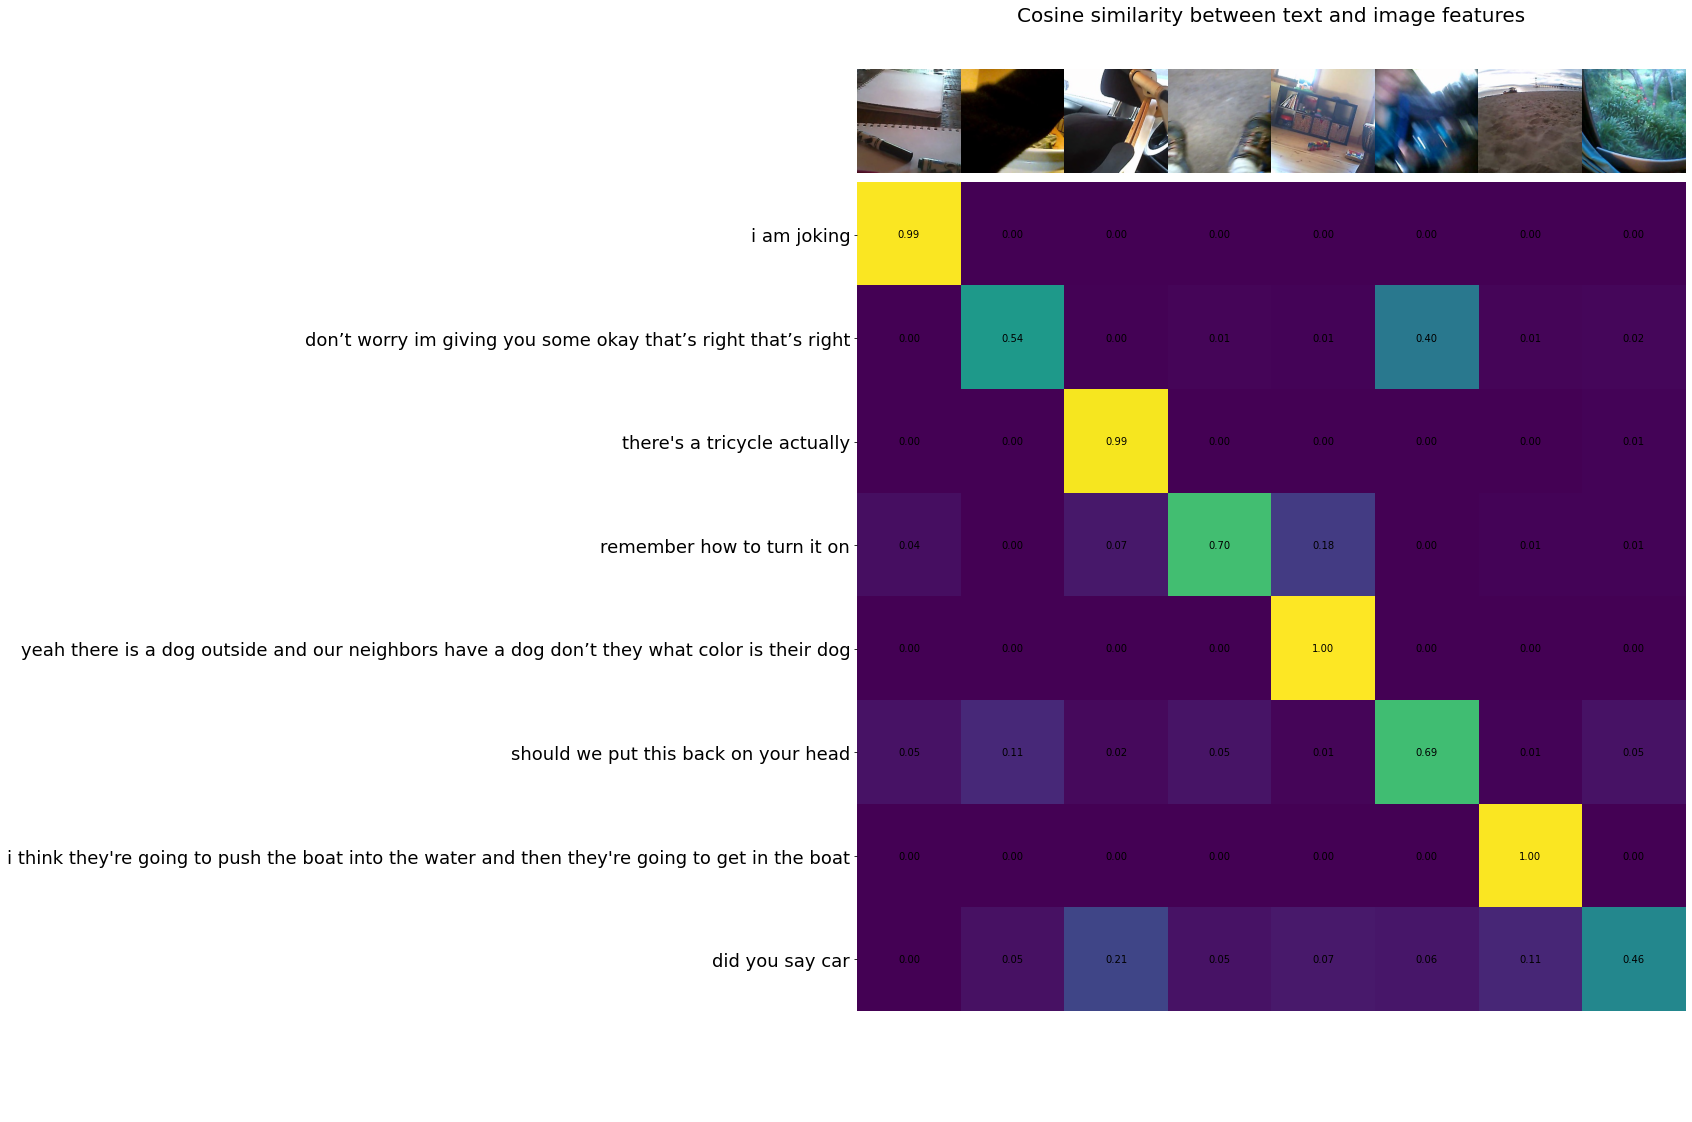

In [8]:
x, y, y_len, raw_y = train_dataloader.next()
x = x.to(device)
y = y.to(device)
y_len = y_len.to(device)
similarity, _ = model(x, y, y_len)
similarity = F.softmax(similarity, dim=1).detach().cpu().numpy()
captions = get_captions(y, y_len)

count = len(captions)
images = n_inv(x)

plt.figure(figsize=(20, 20))
plt.imshow(similarity, vmin=0.0, vmax=1.0)
# plt.colorbar()
plt.yticks(range(count), captions, fontsize=18)
plt.xticks([])
for i, image in enumerate(images):
    image = image.permute((1, 2, 0)).detach().cpu().numpy()
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=10)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)